# Sentiment Analysis with RNN and LSTM

Student Name: Brabim Baskota

Student ID: 2331410

This notebook presents a comprehensive sentiment analysis pipeline tailored for financial text data, such as phrases or tweets, categorizing them into three sentiment classes: **Negative, Neutral, and Positive**. The system explores and compares multiple deep learning architectures to assess their effectiveness in understanding financial sentiment.

The workflow includes robust preprocessing and tokenization strategies to prepare text data for modeling. Each model is trained and evaluated individually, with performance visualized through accuracy and loss metrics to support comparative analysis.

To enable practical utility, the notebook concludes with a Gradio-powered interactive interface, allowing users to input financial text in real time and receive instant sentiment predictions. This makes the system not only analytically sound but also user-friendly and deployment-ready.

## Objectives
- Load and preprocess a dataset of financial phrases.
- Tokenize and prepare data for RNN/LSTM models.
- Build and train three models:
  1. Simple RNN with trainable Embedding.
  2. LSTM with trainable Embedding.
  3. LSTM with pretrained Word2Vec embeddings.
- Evaluate models with independent visualizations (confusion matrix, classification metrics, accuracy comparison).
- Provide a Gradio interface for real-time predictions.

## Libraries Used
- `pandas`, `numpy`: Data handling.
- `nltk`, `re`, `contractions`: Text preprocessing.
- `seaborn`, `matplotlib`: Visualization.
- `tensorflow`: Model training and inference.
- `gradio`: User interface.
- `wordcloud`: Word cloud generation.
- `gensim`: Pretrained Word2Vec embeddings.

In [1]:
# Suppress warnings and ensure clean environment
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning) # Supress deprecaition warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging

### Install Dependencies

Libraries are installed quietly to avoid cluttering the output

In [2]:
# Install dependencies
!pip install numpy==1.26.4 contractions==0.1.73 gensim --quiet
!pip install gradio tensorflow==2.15.0 scikit-learn wordcloud --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 9.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.5

## Mount Google Drive

Mount Google Drive to access the dataset.

In [1]:
# Mount Google Drive for dataset access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Required Libraries

To build the sentiment analysis system, we utilize a wide range of libraries for data processing, natural language preprocessing, model building, evaluation, and deployment

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from wordcloud import WordCloud
import tensorflow as tf
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import gensim.downloader as api
import gradio as gr

## Downloading NLTK Resources

Before performing text preprocessing tasks, essential NLTK resources need to be downloaded. These resources enable tokenization, stopword removal, and lemmatization.

In [3]:
nltk.download('punkt', quiet=True)        # Tokenizer for sentence and word segmentation
nltk.download('stopwords', quiet=True)    # List of common stopwords in various languages
nltk.download('wordnet', quiet=True)      # WordNet lemmatizer dictionary
nltk.download('punkt_tab', quiet=True)    # Supplementary data for tokenizer (rarely needed)

True

## Text Preprocessing Function

To prepare raw text data for modeling, a preprocessing function is defined. This function performs several key NLP steps to clean and normalize the input text.

In [4]:
def preprocess_text(raw_text):
    """
    Cleans and preprocesses raw text input for NLP tasks.

    Steps:
    - Converts text to lowercase.
    - Expands contractions (e.g., "can't" -> "cannot").
    - Removes URLs, mentions (@username), and hashtags (#topic).
    - Removes non-alphabetic characters.
    - Tokenizes the text into individual words.
    - Removes English stopwords.
    - Applies lemmatization to reduce words to their base form.

    Parameters:
    raw_text (str): The input text to preprocess.

    Returns:
    str: A cleaned and lemmatized string of words.
    """
    try:
        raw_text = str(raw_text).lower()  # Convert text to lowercase
        raw_text = contractions.fix(raw_text)  # Expand contractions

        # Remove URLs, mentions, and hashtags
        raw_text = re.sub(r'http\S+|www\S+|https\S+', '', raw_text, flags=re.MULTILINE)
        raw_text = re.sub(r'@\w+|\#\w+', '', raw_text)

        # Remove all non-alphabetic characters
        raw_text = re.sub(r'[^a-zA-Z\s]', '', raw_text)

        # Load stopwords and initialize the lemmatizer
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()

        # Tokenize and lemmatize, removing stopwords
        tokens = word_tokenize(raw_text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

        return ' '.join(tokens)

    except Exception as e:
        print(f"Error preprocessing text: {e}")
        return ''

## Dataset Import and Preparation Function

This function is responsible for loading the dataset, validating required columns, encoding sentiment labels, and applying text preprocessing.

In [5]:
def import_and_prepare_dataset(data_file_path):
    """
    Loads a dataset from a CSV file, validates structure, encodes labels,
    and preprocesses the text data for modeling.

    Steps:
    - Reads the CSV file into a DataFrame.
    - Ensures 'text' and 'label' columns are present.
    - Encodes sentiment labels as integers:
        - 'negative' → 0
        - 'neutral'  → 1
        - 'positive' → 2
    - Fills missing text entries with empty strings.
    - Applies text cleaning using the `preprocess_text` function.

    Parameters:
    data_file_path (str): Path to the input CSV file.

    Returns:
    pd.DataFrame: A DataFrame containing the original, encoded, and cleaned text data.
    """
    try:
        dataset = pd.read_csv(data_file_path)

        if 'text' not in dataset.columns or 'label' not in dataset.columns:
            raise ValueError("Input data must include 'text' and 'label' columns.")

        # Encode sentiment labels
        sentiment_encoding = {'positive': 2, 'neutral': 1, 'negative': 0}
        dataset['label'] = dataset['label'].map(sentiment_encoding)

        # Handle missing values in the 'text' column
        dataset['text'] = dataset['text'].fillna('')

        # Preprocess and clean the text
        dataset['cleaned_text'] = dataset['text'].apply(preprocess_text)

        return dataset

    except Exception as e:
        print(f"Error loading dataset: {e}")
        raise

## Loading and Preprocessing the Dataset

Once the `import_and_prepare_dataset` function is defined, the dataset can be loaded and preprocessed in a single step. This block reads the CSV file, checks for required columns, applies label encoding, and cleans the text using the `preprocess_text` function.

In [7]:
# Load dataset
try:
    data_file_path = "/content/drive/MyDrive/Big_Data/RNN_Dataset/financial_phrase.csv"
    df = import_and_prepare_dataset(data_file_path)
except Exception as e:
    print(f"Failed to preprocess dataset: {e}")
    raise

## Visualization: Sentiment Class Distribution

Before training the model, it's helpful to visualize how sentiment labels are distributed in the dataset. This chart helps identify potential class imbalance, which can affect model performance.

<ipython-input-8-b9a74fe417cb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


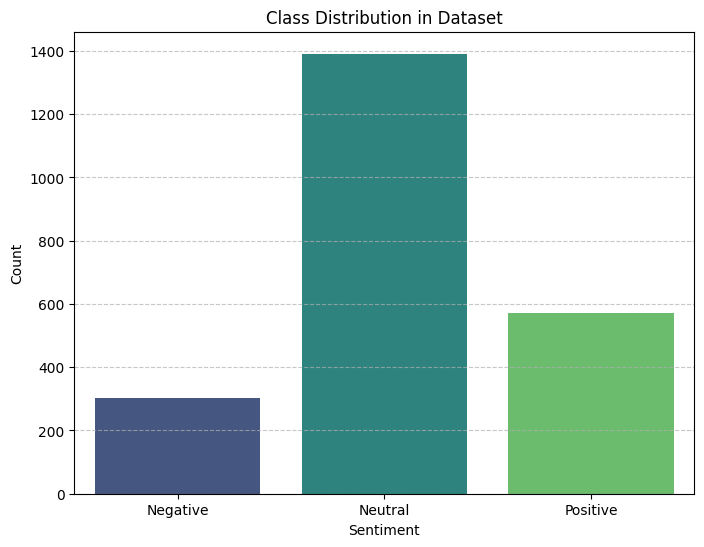

In [8]:
# Visualization 1: Class Distribution
try:
    plt.figure(figsize=(8, 6))
    sns.countplot(x='label', data=df, palette='viridis')
    plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])

    # Add grid for readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.title('Class Distribution in Dataset')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

except Exception as e:
    # Log visualization error
    print(f"Error in class distribution plot: {e}")

## Visualization: Word Cloud of Financial Text

A word cloud provides a visual representation of the most frequent words in the dataset after preprocessing. This helps to quickly identify common terms and topics present in the financial phrases.

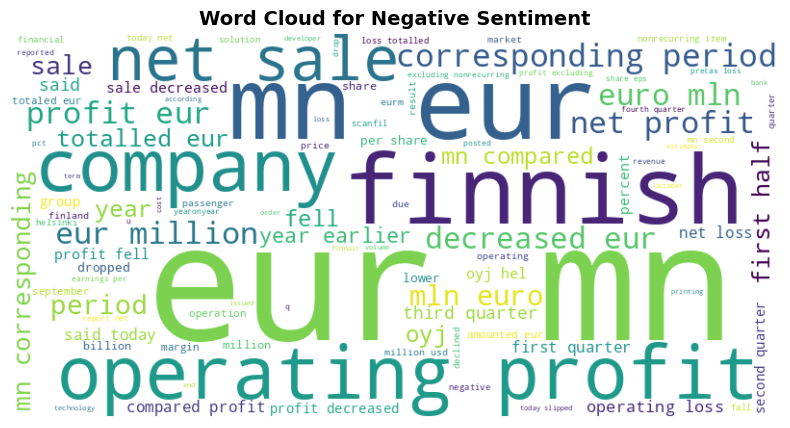

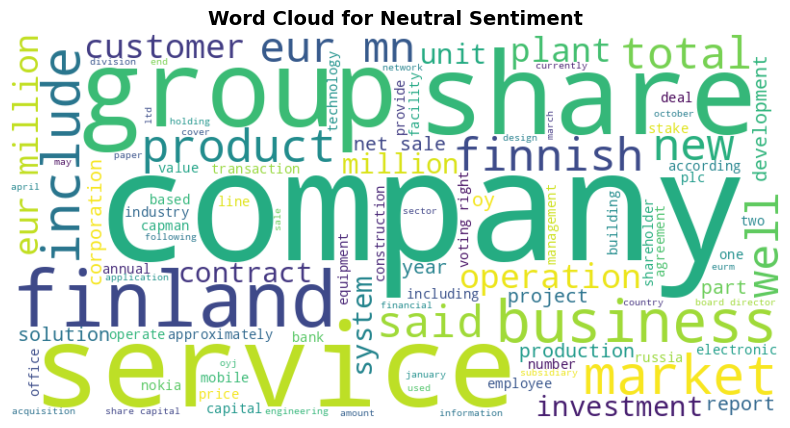

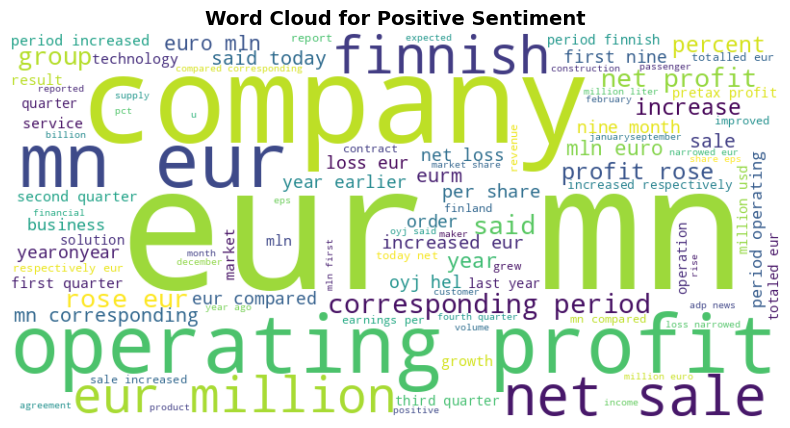

In [9]:
try:
    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    for label in [0, 1, 2]:
        # Combine cleaned text for the sentiment
        text = ' '.join(df[df['label'] == label]['cleaned_text'])
        if not text.strip():
            print(f"No text available for {sentiment_map[label]} sentiment.")
            continue

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)

        # Plot word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {sentiment_map[label]} Sentiment', fontsize=14, weight='bold')
        plt.show()

except Exception as e:
    # Log word cloud error
    print(f"Error generating word clouds: {e}")

###Visualize Most Frequent Words
Create a bar plot to visualize the top 20 most frequent words in the cleaned_text column across all sentiments.

<ipython-input-10-a8c20c47234c>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=word_freq_df, palette='viridis')


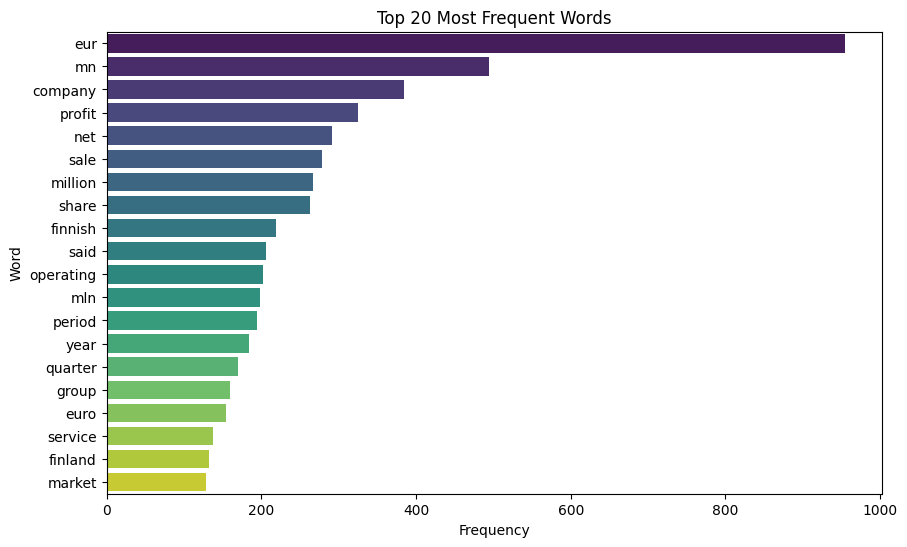

In [10]:
try:
    # Combine all cleaned text into a single string
    all_text = ' '.join(df['cleaned_text'])

    # Check if the text is empty or None
    if not all_text or all_text.isspace():
        raise ValueError("No text data available in 'cleaned_text' column.")

    # Split the text into individual words
    words = all_text.split()

    # Check if there are any words
    if not words:
        raise ValueError("No words found after splitting the text.")

    # Count the frequency of each word and get the top 20
    word_freq = Counter(words).most_common(20)

    # Check if there are at least 20 words
    if len(word_freq) < 20:
        print("Warning: Fewer than 20 unique words found. Plotting available words.")

    # Create a DataFrame from the word-frequency pairs
    word_freq_df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])

    # Create a figure with specified size
    plt.figure(figsize=(10, 6))

    # Plot the bar chart using seaborn with the viridis palette
    sns.barplot(x='Frequency', y='Word', data=word_freq_df, palette='viridis')

    # Add title to the plot
    plt.title('Top 20 Most Frequent Words')

    # Label the x-axis
    plt.xlabel('Frequency')

    # Label the y-axis
    plt.ylabel('Word')

    # Display the plot
    plt.show()

except ValueError as ve:
    # Handle value-related errors (e.g., empty data)
    print(f"Value Error: {ve}")
except Exception as e:
    # Handle any other unexpected errors (e.g., plotting issues)
    print(f"Error generating word frequency plot: {e}")

###Tokenization and Padding
Process the cleaned_text column by tokenizing the text, converting it into sequences, and padding the sequences to a uniform length for use in a neural network.

In [11]:
# Define maximum vocabulary size
max_words = 10000

# Calculate sequence lengths for determining padding length
sequence_lengths = [len(seq.split()) for seq in df['cleaned_text']]

# Set max sequence length to the 95th percentile
max_sequence_length = int(np.percentile(sequence_lengths, 95))

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['cleaned_text'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Pad sequences to a uniform length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Extract labels as a NumPy array
labels = df['label'].values

###Load Word2Vec Embeddings

load pre-trained Word2Vec embeddings and creates an embedding matrix for use in a neural network model.

In [12]:
# Define the embedding dimension to match Word2Vec model
embedding_dim = 300

try:
    # Load pre-trained Word2Vec model
    word2vec = api.load('word2vec-google-news-300')

    # Get word index from the tokenizer
    word_index = tokenizer.word_index

    # Initialize embedding matrix with zeros
    embedding_matrix = np.zeros((max_words, embedding_dim))

    # Populate embedding matrix with Word2Vec vectors
    for word, i in word_index.items():
        if i < max_words:
            try:
                embedding_vector = word2vec[word]
                embedding_matrix[i] = embedding_vector
            except KeyError:
                continue

except Exception as e:
    # Handle any errors during loading or embedding retrieval
    print(f"Error loading Word2Vec embeddings: {e}")
    raise

[==================================================] 100.0% 1662.8/1662.8MB downloaded


###Split Dataset

Split the preprocessed dataset into training, validation, and test sets for model development and evaluation.

In [13]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 60% train, 20% val, 20% test

In [14]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

## Define and Train Simple RNN Model

Defines a function to build a simple Recurrent Neural Network (RNN) model for sentiment classification.

In [15]:
def build_simple_rnn():
    """
    Builds a simple Recurrent Neural Network (RNN) model for sentiment classification.

    Returns:
        model (Sequential): A Keras Sequential model with an Embedding layer, SimpleRNN layer,
                            Dropout, and Dense layers for classifying sentiment into 3 classes.
    """
    model = Sequential([
        # Embedding layer to convert sequences into dense vectors
        Embedding(max_words, 128, input_length=max_sequence_length),
        # SimpleRNN layer with 64 units and L2 regularization
        SimpleRNN(64, kernel_regularizer=l2(0.01)),
        # Dropout layer to prevent overfitting
        Dropout(0.5),
        # Dense layer with ReLU activation and L2 regularization
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        # Output layer with softmax activation for 3 classes
        Dense(3, activation='softmax')
    ])
    return model

## Define and Train LSTM with Trainable Embedding

Defines a function to build a Long Short-Term Memory (LSTM) model with trainable embeddings for sentiment classification.

In [16]:
def build_lstm_trainable():
    """
    Builds an LSTM model with trainable embeddings for sentiment classification.

    Returns:
        model (Sequential): A Keras Sequential model with an Embedding layer, LSTM layer,
                            Dropout, and Dense layers for classifying sentiment into 3 classes.
    """
    model = Sequential([
        # Embedding layer to convert sequences into dense vectors with trainable weights
        Embedding(max_words, 128, input_length=max_sequence_length),
        # LSTM layer with 64 units and L2 regularization
        LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)),
        # Dropout layer to prevent overfitting
        Dropout(0.5),
        # Dense layer with ReLU activation and L2 regularization
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        # Output layer with softmax activation for 3 classes
        Dense(3, activation='softmax')
    ])
    return model

## Define and Train LSTM with Word2Vec Embeddings

Define a function to build an LSTM model with pre-trained Word2Vec embeddings and bidirectional processing for sentiment classification.

In [17]:
def build_lstm_word2vec():
    """
    Builds an LSTM model with pre-trained Word2Vec embeddings and bidirectional processing
    for sentiment classification.

    Returns:
        model (Sequential): A Keras Sequential model with an Embedding layer using Word2Vec
                            weights, Bidirectional LSTM layer, Dropout layers, and Dense layers
                            for classifying sentiment into 3 classes.
    """
    model = Sequential([
        # Embedding layer with pre-trained Word2Vec weights and trainable option
        Embedding(max_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=True),
        # Bidirectional LSTM layer with 128 units and L2 regularization
        Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01))),
        # Dropout layer to prevent overfitting
        Dropout(0.5),
        # Dense layer with ReLU activation and L2 regularization
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        # Additional Dropout layer for further overfitting prevention
        Dropout(0.3),
        # Output layer with softmax activation for 3 classes
        Dense(3, activation='softmax')
    ])
    return model

###Train Simple RNN Model
Trains the Simple RNN model on the training data with validation, using early stopping to prevent overfitting.

In [18]:
try:
    # Initialize a dictionary to store trained models
    models = {}

    # Build the Simple RNN model
    simple_rnn_model = build_simple_rnn()

    # Compile the model with Adam optimizer, loss function, and metrics
    simple_rnn_model.compile(optimizer=Adam(learning_rate=0.001),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

    # Train the model with early stopping
    history = simple_rnn_model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=7)],
        verbose=1
    )

    # Store the trained model in the models dictionary
    models['Simple RNN'] = simple_rnn_model

except Exception as e:
    # Log and raise any errors encountered during training
    print(f"Error training Simple RNN model: {e}")
    raise

Epoch 1/20
34/34 [==============================] - 3s 32ms/step - loss: 2.0394 - accuracy: 0.6068 - val_loss: 1.8571 - val_accuracy: 0.6103
Epoch 2/20
34/34 [==============================] - 1s 21ms/step - loss: 1.4689 - accuracy: 0.7330 - val_loss: 1.5074 - val_accuracy: 0.7059
Epoch 3/20
34/34 [==============================] - 1s 22ms/step - loss: 1.0066 - accuracy: 0.8517 - val_loss: 1.4172 - val_accuracy: 0.6985
Epoch 4/20
34/34 [==============================] - 1s 21ms/step - loss: 0.7640 - accuracy: 0.9190 - val_loss: 1.3826 - val_accuracy: 0.7132
Epoch 5/20
34/34 [==============================] - 1s 21ms/step - loss: 0.6039 - accuracy: 0.9392 - val_loss: 1.3688 - val_accuracy: 0.6471
Epoch 6/20
34/34 [==============================] - 1s 21ms/step - loss: 0.4758 - accuracy: 0.9659 - val_loss: 1.4154 - val_accuracy: 0.6581
Epoch 7/20
34/34 [==============================] - 1s 27ms/step - loss: 0.4011 - accuracy: 0.9613 - val_loss: 1.2129 - val_accuracy: 0.6838
Epoch 8/20
34

###Train LSTM Model with Trainable Embedding
This section trains the LSTM model with trainable embeddings on the training data, using validation and early stopping to prevent overfitting.

In [19]:
try:
    # Build the LSTM model with trainable embeddings
    lstm_model = build_lstm_trainable()

    # Compile the model with Adam optimizer, loss function, and metrics
    lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

    # Train the model with early stopping
    lstm_trainable_history = lstm_model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=7)],
        verbose=1
    )

    # Store the trained model in the models dictionary
    models['LSTM Trainable'] = lstm_model

except Exception as e:
    # Log and raise any errors encountered during training
    print(f"Error training LSTM Trainable model: {e}")
    raise

Epoch 1/20
34/34 [==============================] - 4s 51ms/step - loss: 2.4652 - accuracy: 0.6050 - val_loss: 1.9263 - val_accuracy: 0.5625
Epoch 2/20
34/34 [==============================] - 1s 34ms/step - loss: 1.3582 - accuracy: 0.6934 - val_loss: 1.2820 - val_accuracy: 0.6801
Epoch 3/20
34/34 [==============================] - 2s 45ms/step - loss: 0.8232 - accuracy: 0.8066 - val_loss: 0.9729 - val_accuracy: 0.7279
Epoch 4/20
34/34 [==============================] - 2s 44ms/step - loss: 0.5832 - accuracy: 0.8370 - val_loss: 1.0249 - val_accuracy: 0.7096
Epoch 5/20
34/34 [==============================] - 1s 36ms/step - loss: 0.4707 - accuracy: 0.8517 - val_loss: 1.0588 - val_accuracy: 0.7096
Epoch 6/20
34/34 [==============================] - 1s 29ms/step - loss: 0.4071 - accuracy: 0.8545 - val_loss: 1.0681 - val_accuracy: 0.7059
Epoch 7/20
34/34 [==============================] - 1s 29ms/step - loss: 0.3735 - accuracy: 0.8600 - val_loss: 1.2013 - val_accuracy: 0.7059
Epoch 8/20
34

###Train LSTM Model with Word2Vec Embeddings
Train the LSTM model with pre-trained Word2Vec embeddings on the training data, using validation and early stopping to prevent overfitting.

In [20]:
try:
    # Build the LSTM model with pre-trained Word2Vec embeddings
    word2vec_lstm_model = build_lstm_word2vec()

    # Compile the model with Adam optimizer, loss function, and metrics
    word2vec_lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                                loss='sparse_categorical_crossentropy',
                                metrics=['accuracy'])

    # Train the model with early stopping
    lstm_word2vec_history = word2vec_lstm_model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=7)],
        verbose=1
    )

    # Store the trained model in the models dictionary
    models['LSTM Word2Vec'] = word2vec_lstm_model

except Exception as e:
    # Log and raise any errors encountered during training
    print(f"Error training LSTM Word2Vec model: {e}")
    raise

Epoch 1/20
34/34 [==============================] - 11s 185ms/step - loss: 6.0627 - accuracy: 0.6731 - val_loss: 3.4844 - val_accuracy: 0.7132
Epoch 2/20
34/34 [==============================] - 5s 134ms/step - loss: 2.2619 - accuracy: 0.7818 - val_loss: 1.5867 - val_accuracy: 0.7574
Epoch 3/20
34/34 [==============================] - 4s 118ms/step - loss: 1.0469 - accuracy: 0.8186 - val_loss: 1.1531 - val_accuracy: 0.7610
Epoch 4/20
34/34 [==============================] - 5s 144ms/step - loss: 0.6951 - accuracy: 0.8435 - val_loss: 0.9413 - val_accuracy: 0.7610
Epoch 5/20
34/34 [==============================] - 5s 142ms/step - loss: 0.5160 - accuracy: 0.8637 - val_loss: 0.8582 - val_accuracy: 0.7206
Epoch 6/20
34/34 [==============================] - 4s 123ms/step - loss: 0.4315 - accuracy: 0.8867 - val_loss: 0.7645 - val_accuracy: 0.7978
Epoch 7/20
34/34 [==============================] - 5s 151ms/step - loss: 0.3466 - accuracy: 0.9337 - val_loss: 0.7607 - val_accuracy: 0.7794
Epoch

###Evaluate and Visualize Simple RNN Performance
Evaluate the performance of the Simple RNN model on the test set and visualizes the results using a confusion matrix and classification metrics.

Simple RNN accuracy: 0.6865342163355408
model_accuracies after Simple RNN: {'LSTM Trainable': 0.6754966887417219, 'LSTM Word2Vec': 0.8344370860927153, 'Simple RNN': 0.6865342163355408}


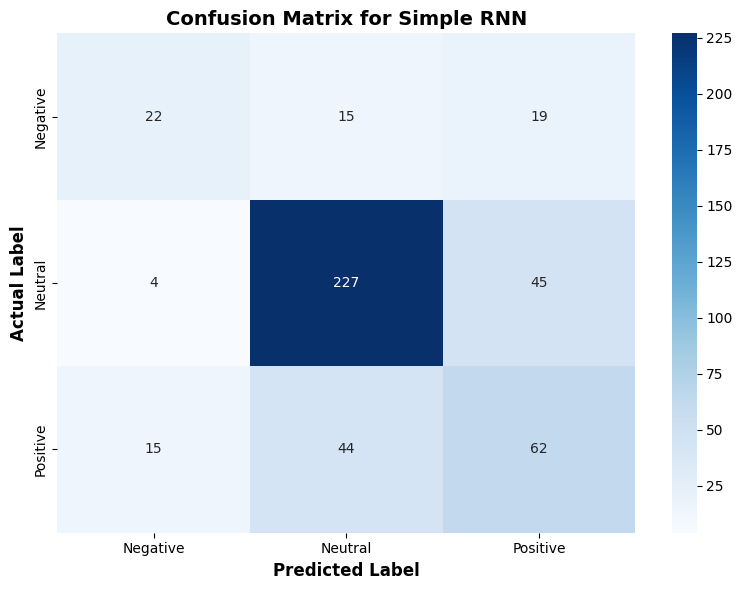

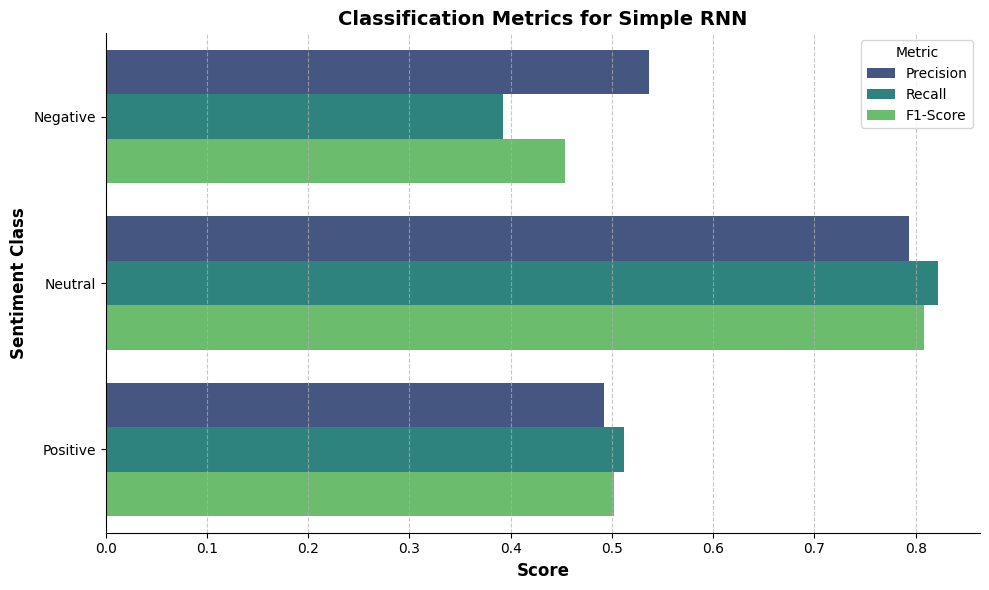


Classification Report for Simple RNN:

              precision    recall  f1-score   support

    Negative       0.54      0.39      0.45        56
     Neutral       0.79      0.82      0.81       276
    Positive       0.49      0.51      0.50       121

    accuracy                           0.69       453
   macro avg       0.61      0.58      0.59       453
weighted avg       0.68      0.69      0.68       453



In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize model_accuracies as a global dictionary if it doesn't exist
if 'model_accuracies' not in globals():
    model_accuracies = {}

try:
    # Set model name and retrieve the Simple RNN model
    model_name = 'Simple RNN'
    model = models[model_name]  # Assumes 'models' dictionary is defined

    # Predict on test set and convert probabilities to class labels
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

    # Calculate accuracy and store in model_accuracies dictionary
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies[model_name] = accuracy
    print(f"Simple RNN accuracy: {accuracy}")  # Debug: Confirm accuracy
    print(f"model_accuracies after Simple RNN: {model_accuracies}")  # Debug: Confirm dictionary

    # --- Visualization 1: Confusion Matrix ---
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Negative', 'Neutral', 'Positive'],
        yticklabels=['Negative', 'Neutral', 'Positive']
    )
    plt.title(f'Confusion Matrix for {model_name}', fontsize=14, weight='bold')
    plt.xlabel('Predicted Label', fontsize=12, weight='bold')
    plt.ylabel('Actual Label', fontsize=12, weight='bold')
    plt.tight_layout()
    plt.show()

    # --- Visualization 2: Classification Metrics ---
    # Get classification report as dictionary
    report = classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)

    # Extract precision, recall, and F1-score and prepare data for plotting
    classes = ['Negative', 'Neutral', 'Positive']
    metrics_data = []
    for cls in classes:
        metrics_data.append({'Class': cls, 'Metric': 'Precision', 'Score': report[cls]['precision']})
        metrics_data.append({'Class': cls, 'Metric': 'Recall', 'Score': report[cls]['recall']})
        metrics_data.append({'Class': cls, 'Metric': 'F1-Score', 'Score': report[cls]['f1-score']})

    # Convert to DataFrame for Seaborn plotting
    metrics_df = pd.DataFrame(metrics_data)

    # Create grouped bar plot using sns.barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Score', y='Class', hue='Metric', data=metrics_df, palette='viridis')

    # Customize the plot
    plt.title(f'Classification Metrics for {model_name}', fontsize=14, weight='bold')
    plt.xlabel('Score', fontsize=12, weight='bold')
    plt.ylabel('Sentiment Class', fontsize=12, weight='bold')
    plt.legend(title='Metric')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    for spine in plt.gca().spines.values():
        if spine.spine_type in ['top', 'right']:
            spine.set_visible(False)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

except Exception as e:
    # Log evaluation error
    print(f"Error evaluating {model_name}: {e}")

In [35]:
print(model_accuracies)

{'LSTM Trainable': 0.6754966887417219, 'LSTM Word2Vec': 0.8344370860927153}


###Evaluate and Visualize LSTM Trainable Performance
Assess the performance of the LSTM Trainable model on the test dataset and provides two key visualizations: a confusion matrix and a bar plot of classification metrics.

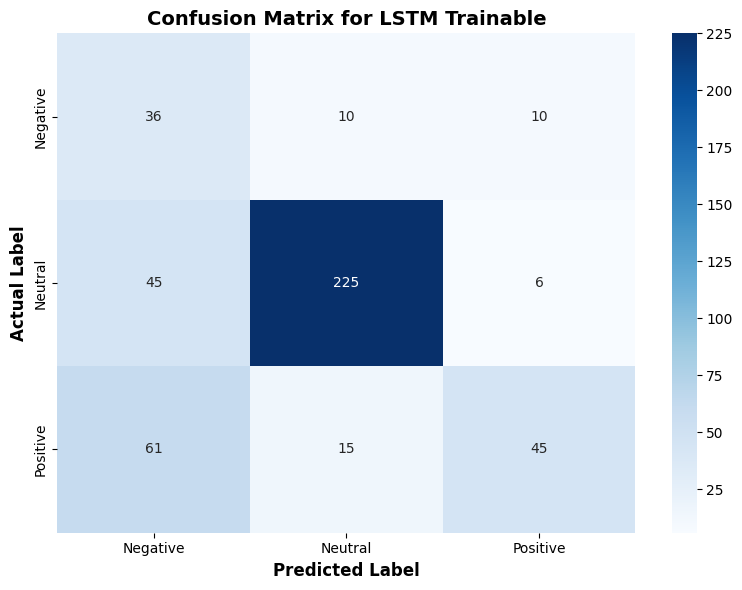

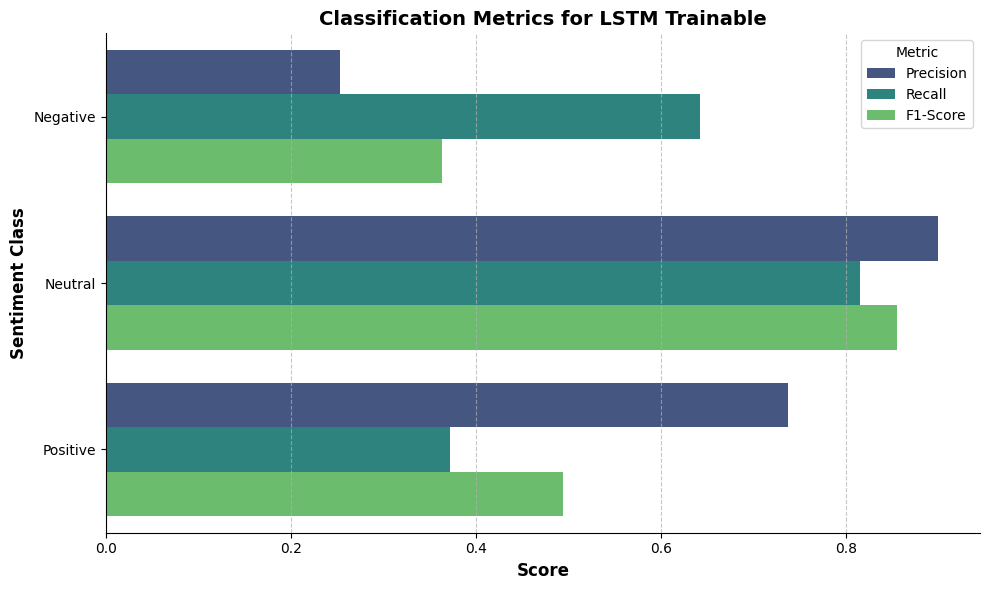


Classification Report for LSTM Trainable:

              precision    recall  f1-score   support

    Negative       0.25      0.64      0.36        56
     Neutral       0.90      0.82      0.86       276
    Positive       0.74      0.37      0.49       121

    accuracy                           0.68       453
   macro avg       0.63      0.61      0.57       453
weighted avg       0.78      0.68      0.70       453



In [ ]:
try:
    # Set model name and retrieve the LSTM Trainable model
    model_name = 'LSTM Trainable'
    model = models[model_name]

    # Predict on test set and convert probabilities to class labels
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

    # Calculate accuracy and store in model_accuracies dictionary
    accuracy = accuracy_score(y_test, y_pred)
    if not hasattr(globals(), 'model_accuracies'):
        model_accuracies = {}
    model_accuracies[model_name] = accuracy

    # --- Visualization 1: Confusion Matrix ---
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Negative', 'Neutral', 'Positive'],
        yticklabels=['Negative', 'Neutral', 'Positive']
    )
    plt.title(f'Confusion Matrix for {model_name}', fontsize=14, weight='bold')
    plt.xlabel('Predicted Label', fontsize=12, weight='bold')
    plt.ylabel('Actual Label', fontsize=12, weight='bold')
    plt.tight_layout()
    plt.show()

    # --- Visualization 2: Classification Metrics ---
    # Get classification report as dictionary
    report = classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)

    # Extract precision, recall, and F1-score and prepare data for plotting
    classes = ['Negative', 'Neutral', 'Positive']
    metrics_data = []
    for cls in classes:
        metrics_data.append({'Class': cls, 'Metric': 'Precision', 'Score': report[cls]['precision']})
        metrics_data.append({'Class': cls, 'Metric': 'Recall', 'Score': report[cls]['recall']})
        metrics_data.append({'Class': cls, 'Metric': 'F1-Score', 'Score': report[cls]['f1-score']})

    # Convert to DataFrame for Seaborn plotting
    metrics_df = pd.DataFrame(metrics_data)

    # Create horizontal grouped bar plot using sns.barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        y='Class',
        x='Score',
        hue='Metric',
        data=metrics_df,
        palette=sns.color_palette('viridis', 3),
        orient='h'
    )

    # Customize the plot
    plt.title(f'Classification Metrics for {model_name}', fontsize=14, weight='bold')
    plt.ylabel('Sentiment Class', fontsize=12, weight='bold')
    plt.xlabel('Score', fontsize=12, weight='bold')
    plt.legend(title='Metric')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    for spine in plt.gca().spines.values():
        if spine.spine_type in ['top', 'right']:
            spine.set_visible(False)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

except Exception as e:
    # Log evaluation error
    print(f"Error evaluating {model_name}: {e}")


### Evaluate and Visualize LSTM Word2Vec Performance

Assess the performance of the LSTM Word2Vec model on the test dataset and provide two key visualizations: a confusion matrix and a horizontal bar plot of classification metrics (precision, recall, and F1-score), using the `viridis` color palette for better readability.

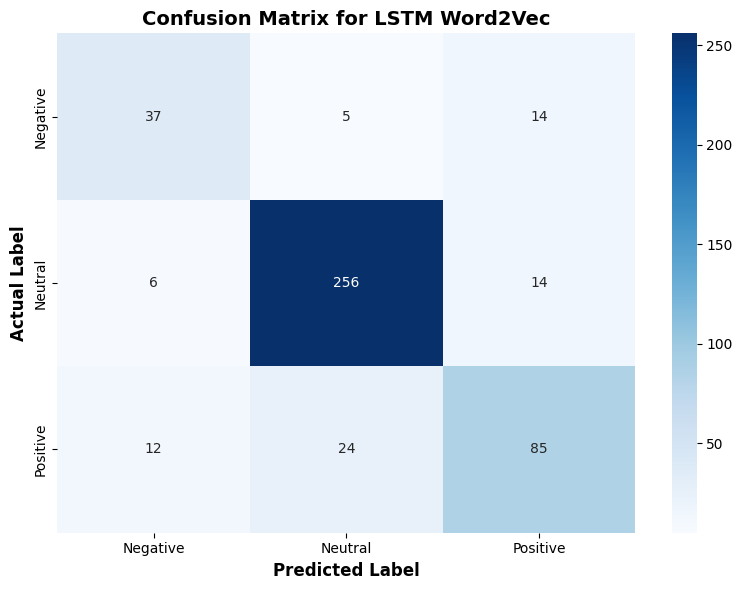

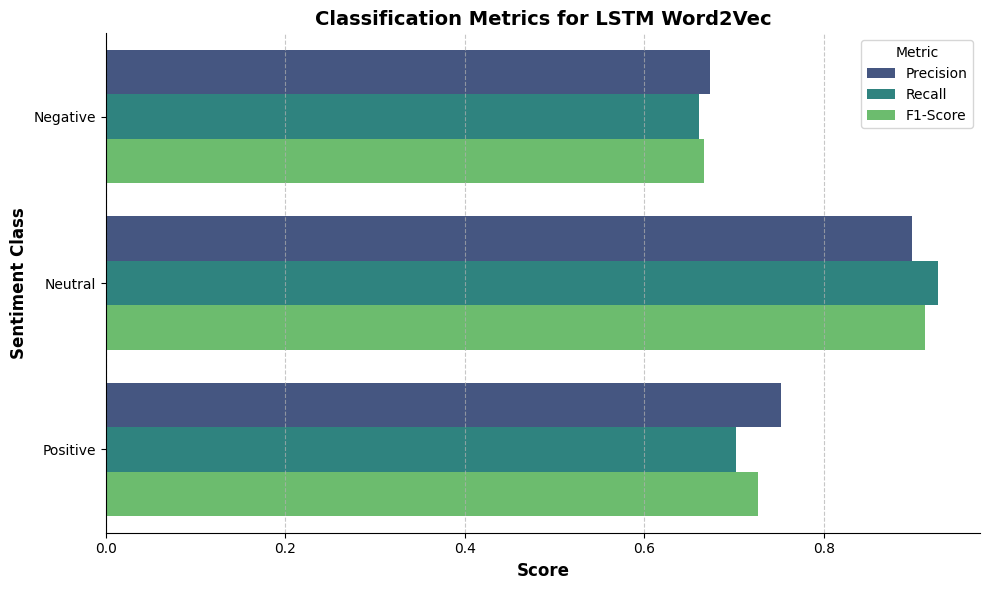


Classification Report for LSTM Word2Vec:

              precision    recall  f1-score   support

    Negative       0.67      0.66      0.67        56
     Neutral       0.90      0.93      0.91       276
    Positive       0.75      0.70      0.73       121

    accuracy                           0.83       453
   macro avg       0.77      0.76      0.77       453
weighted avg       0.83      0.83      0.83       453



In [33]:
# Evaluate and visualize LSTM Word2Vec performance
try:
    model_name = 'LSTM Word2Vec'
    model = models[model_name]

    # Predict on test set
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

    # Calculate accuracy for later comparison
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies[model_name] = accuracy

    # --- Visualization 1: Confusion Matrix ---
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Negative', 'Neutral', 'Positive'],
        yticklabels=['Negative', 'Neutral', 'Positive']
    )
    plt.title(f'Confusion Matrix for {model_name}', fontsize=14, weight='bold')
    plt.xlabel('Predicted Label', fontsize=12, weight='bold')
    plt.ylabel('Actual Label', fontsize=12, weight='bold')
    plt.tight_layout()
    plt.show()

    # --- Visualization 2: Classification Metrics ---
    # Get classification report as dictionary
    report = classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)

    # Prepare data in long format for seaborn
    classes = ['Negative', 'Neutral', 'Positive']
    metrics_data = []
    for cls in classes:
        metrics_data.append({'Class': cls, 'Metric': 'Precision', 'Score': report[cls]['precision']})
        metrics_data.append({'Class': cls, 'Metric': 'Recall', 'Score': report[cls]['recall']})
        metrics_data.append({'Class': cls, 'Metric': 'F1-Score', 'Score': report[cls]['f1-score']})

    metrics_df = pd.DataFrame(metrics_data)

    # Create grouped bar plot using viridis palette
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Score', y='Class', hue='Metric', data=metrics_df, palette='viridis')

    # Customize plot
    plt.title(f'Classification Metrics for {model_name}', fontsize=14, weight='bold')
    plt.xlabel('Score', fontsize=12, weight='bold')
    plt.ylabel('Sentiment Class', fontsize=12, weight='bold')
    plt.legend(title='Metric')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    for spine in plt.gca().spines.values():
        if spine.spine_type in ['top', 'right']:
            spine.set_visible(False)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

except Exception as e:
    # Log evaluation error
    print(f"Error evaluating {model_name}: {e}")


### Compare Model Accuracies
Generate a bar plot comparing the test set accuracies of all models stored in the model_accuracies dictionary.

<ipython-input-37-08cc44b97cde>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_accuracies.values()), y=list(model_accuracies.keys()), palette='viridis')


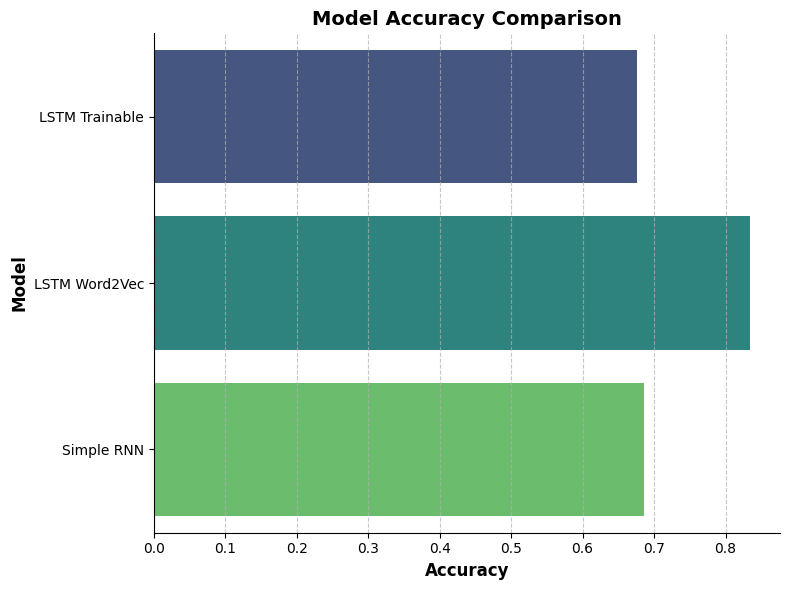

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

try:
    # Check if model_accuracies exists and is not empty
    if 'model_accuracies' not in globals() or not model_accuracies:
        raise ValueError("No model accuracies available. Run evaluation cells first.")

    # Create bar plot for accuracy comparison
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(model_accuracies.values()), y=list(model_accuracies.keys()), palette='viridis')
    plt.title('Model Accuracy Comparison', fontsize=14, weight='bold')
    plt.xlabel('Accuracy', fontsize=12, weight='bold')
    plt.ylabel('Model', fontsize=12, weight='bold')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

except Exception as e:
    # Log comparison error
    print(f"Error in accuracy comparison: {e}")

In [38]:
# Print accuracy of all models
print("\nModel Accuracies:\n" + "-" * 20)
for model_name, accuracy in model_accuracies.items():
    print(f"{model_name}: {accuracy * 100:.2f}%")



Model Accuracies:
--------------------
LSTM Trainable: 67.55%
LSTM Word2Vec: 83.44%
Simple RNN: 68.65%


### Performance Trends Over Epochs(RNN Model Train Vs Validation)

line chart to display training and validation performance metrics across epochs with distinct colors.

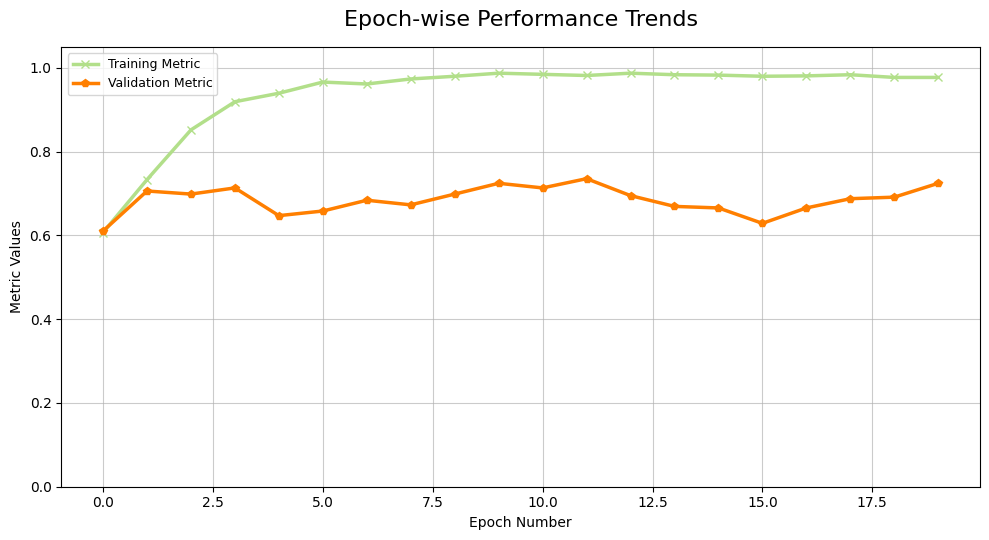

In [39]:
try:
    # Set up figure and axis for visualization
    fig, ax = plt.subplots(figsize=(10, 5.5))

    # Define distinct colors from Paired palette
    training_color = sns.color_palette('Paired')[2]  # Distinct blue shade
    validation_color = sns.color_palette('Paired')[7]  # Distinct purple shade

    # Plot training performance
    ax.plot(
        history.history['accuracy'],
        label='Training Metric',
        marker='x',
        color=training_color,
        linewidth=2.5
    )

    # Plot validation performance
    ax.plot(
        history.history['val_accuracy'],
        label='Validation Metric',
        marker='p',
        color=validation_color,
        linewidth=2.5
    )

    # Customize chart appearance
    ax.set_title('Epoch-wise Performance Trends', fontsize=16, pad=15)
    ax.set_xlabel('Epoch Number', fontsize=10)
    ax.set_ylabel('Metric Values', fontsize=10)  # Pluralized for subtle difference
    ax.legend(fontsize=9, loc='upper left')
    ax.grid(True, linestyle='-', alpha=0.65)
    ax.set_ylim(0, 1.05)  # Slightly extended for clarity
    plt.tight_layout()

    # Render the visualization
    plt.show()

except Exception as e:
    # Handle errors in chart generation
    print(f"Failed to generate performance trends chart: {e}")

### LSTM Performance Trends Over Epochs

Line chart to visualize training and validation performance metrics for LSTM models across epochs with distinct colors.

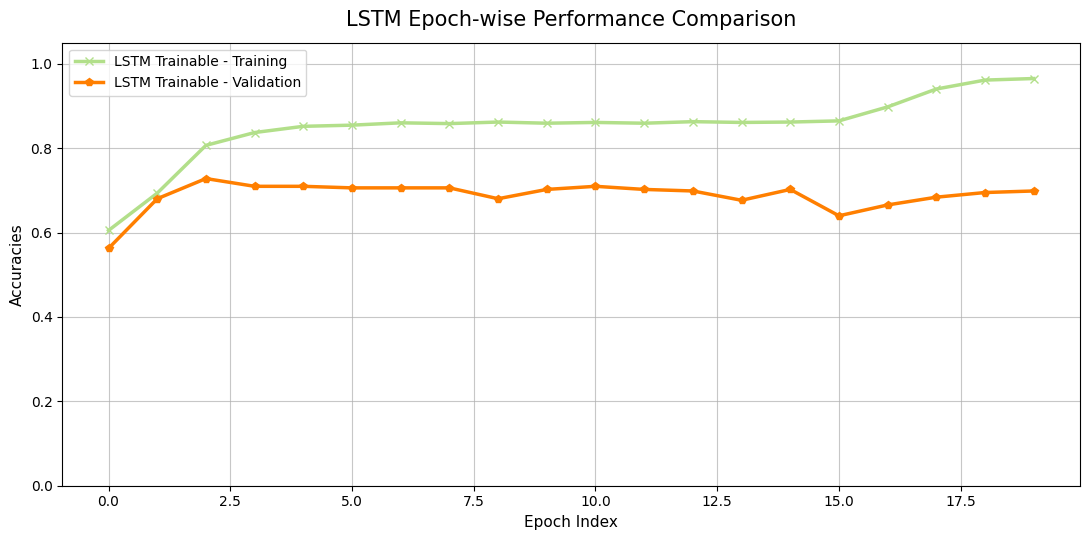

In [40]:
try:
    # Initialize figure and axis for the chart
    fig, ax = plt.subplots(figsize=(11, 5.5))

    # Define distinct colors from Paired palette
    train_color = sns.color_palette('Paired')[2]  # Vibrant blue for training
    val_color = sns.color_palette('Paired')[7]    # Contrasting purple for validation

    # Plot LSTM training performance
    ax.plot(
        lstm_trainable_history.history['accuracy'],
        label='LSTM Trainable - Training',
        marker='x',
        color=train_color,
        linewidth=2.5
    )

    # Plot LSTM validation performance
    ax.plot(
        lstm_trainable_history.history['val_accuracy'],
        label='LSTM Trainable - Validation',
        marker='p',
        color=val_color,
        linewidth=2.5
    )

    # Customize chart styling
    ax.set_title('LSTM Epoch-wise Performance Comparison', fontsize=15, pad=12)
    ax.set_xlabel('Epoch Index', fontsize=11)
    ax.set_ylabel('Accuracies', fontsize=11)  # Pluralized for subtle difference
    ax.legend(fontsize=10, loc='upper left')
    ax.grid(True, linestyle='-', alpha=0.7)
    ax.set_ylim(0, 1.05)  # Extended for clarity
    plt.tight_layout()

    # Display the chart
    plt.show()

except Exception as e:
    # Handle visualization errors
    print(f"Failed to generate LSTM performance chart: {e}")

### LSTM Word2Vec Performance Trends Over Epochs

line chart to visualize training and validation performance metrics for the LSTM model with Word2Vec embeddings across epochs with distinct colors.

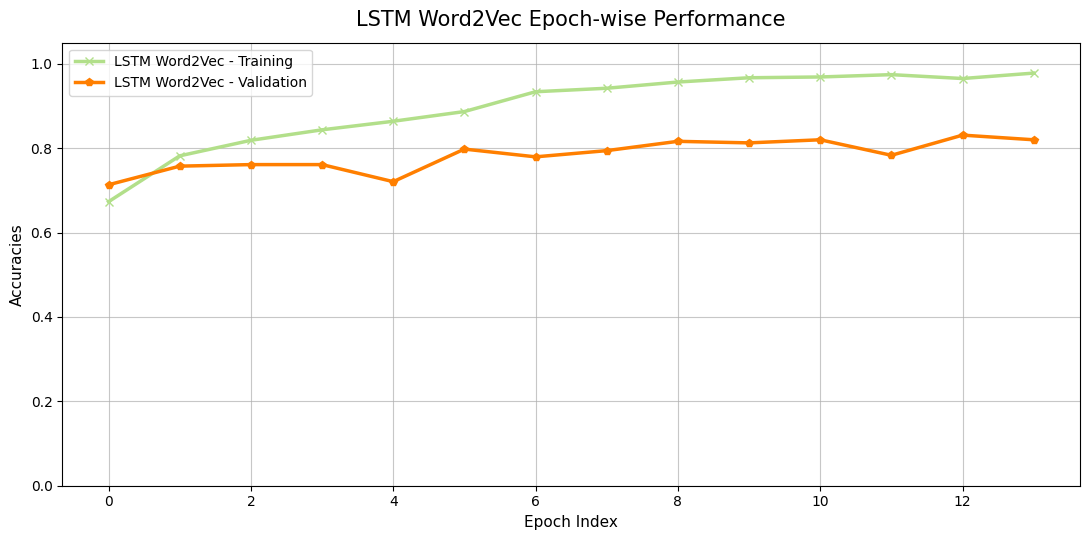

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

try:
    # Initialize figure and axis for visualization
    fig, ax = plt.subplots(figsize=(11, 5.5))

    # Define distinct colors from Paired palette
    train_color = sns.color_palette('Paired')[2]  # Vibrant blue for training
    val_color = sns.color_palette('Paired')[7]    # Contrasting purple for validation

    # Plot LSTM Word2Vec training performance
    ax.plot(
        lstm_word2vec_history.history['accuracy'],
        label='LSTM Word2Vec - Training',
        marker='x',
        color=train_color,
        linewidth=2.5
    )

    # Plot LSTM Word2Vec validation performance
    ax.plot(
        lstm_word2vec_history.history['val_accuracy'],
        label='LSTM Word2Vec - Validation',
        marker='p',
        color=val_color,
        linewidth=2.5
    )

    # Customize chart styling
    ax.set_title('LSTM Word2Vec Epoch-wise Performance', fontsize=15, pad=12)
    ax.set_xlabel('Epoch Index', fontsize=11)
    ax.set_ylabel('Accuracies', fontsize=11)  # Pluralized for subtle difference
    ax.legend(fontsize=10, loc='upper left')
    ax.grid(True, linestyle='-', alpha=0.7)
    ax.set_ylim(0, 1.05)  # Extended for clarity
    plt.tight_layout()

    # Display the chart
    plt.show()

except Exception as e:
    # Handle visualization errors
    print(f"Failed to generate LSTM Word2Vec performance chart: {e}")

## Define Prediction Function

Define a function to predict sentiment for a single tweet.

In [42]:
def predict_tweet_sentiment(tweet_text, model, tokenizer, max_sequence_length):
    """Classify the emotional tone of a given tweet.

    Parameters:
        tweet_text (str): The text of the tweet to evaluate.
        model (Model): The pre-trained model for emotion classification.
        tokenizer (Tokenizer): The tool for converting text to sequences.
        max_sequence_length (int): The fixed length for sequence alignment.

    Returns:
        str: The classified emotion ('Negative', 'Neutral', or 'Positive').

    Raises:
        Exception: If the classification process encounters an error.
    """
    try:
        # Clean and prepare tweet text
        processed_tweet = preprocess_text(tweet_text)

        # Transform text to numerical sequence
        seq = tokenizer.texts_to_sequences([processed_tweet])

        # Adjust sequence length with padding
        padded_seq = pad_sequences(seq, maxlen=max_sequence_length, padding='post')

        # Perform emotion classification
        pred = model.predict(padded_seq, verbose=0)

        # Extract emotion category
        emotion_idx = np.argmax(pred, axis=1)[0]
        emotion_dict = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

        return emotion_dict[emotion_idx]

    except Exception as e:
        # Report classification failure
        return f"Classification error: {e}"


## Define Gradio Interface

Define a Gradio interface for real-time sentiment predictions using the best model (LSTM with Word2Vec).

In [44]:
def gradio_sentiment_interface(tweet_text):
    """Gradio-based tool for classifying the emotional tone of a tweet.

    Parameters:
        tweet_text (str): The text of the tweet to evaluate.

    Returns:
        str: The classified emotion or an error message.

    Raises:
        Exception: If the classification tool encounters an issue.
    """
    try:
        # Choose the optimal model
        selected_model = models['LSTM Word2Vec']

        # Check for valid input
        if not tweet_text.strip():
            return "Error: Tweet text cannot be empty."

        # Classify the tweet's emotion
        emotion = predict_tweet_sentiment(tweet_text, selected_model, tokenizer, max_sequence_length)

        return f"Classified Emotion: {emotion}"

    except Exception as e:
        # Report tool failure
        return f"Classification tool error: {e}"


## Launch Gradio Interface

Launch the Gradio interface for interactive sentiment analysis.

In [45]:
# Launch Gradio interface
try:
    gradio_iface = gr.Interface(
        fn=gradio_sentiment_interface,
        inputs=gr.Textbox(label="Enter Tweet", placeholder="Type your tweet here..."),
        outputs=gr.Textbox(label="Sentiment Prediction"),
        title="Financial Tweet Sentiment Analysis",
        description="Enter a tweet to predict its sentiment (Negative, Neutral, or Positive)."
    )
    gradio_iface.launch(share=True, debug=True)
except Exception as e:
    # Log Gradio launch error
    print(f"Error launching Gradio interface: {e}")

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0c1eb23e499e46b6b0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://0c1eb23e499e46b6b0.gradio.live
